In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '../data/kvasir_capsule/metadata.csv'
metadata = pd.read_csv(file_path, delimiter=';')
# Create the filtered metadata
filtered_metadata = metadata[
    (metadata['finding_class'] != 'Normal clean mucosa') &
    (metadata['finding_class'] != 'Ileocecal valve') &
    (metadata['finding_class'] != 'Pylorus') &
    (metadata['finding_class'] != 'Ampulla of Vater') &
    (metadata['finding_class'] != 'Reduced Mucosal View')
]


# Group by finding class and count the number of unique video_ids (patients) and filenames (images)
class_counts_normal = metadata.groupby('finding_class').agg(
    num_patients=('video_id', 'nunique'),
    num_images=('filename', 'count')
).reset_index()

class_counts_filtered = filtered_metadata.groupby('finding_class').agg(
    num_patients=('video_id', 'nunique'),
    num_images=('filename', 'count')
).reset_index()

# Set up the matplotlib figure and axes for two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot for normal metadata
colors_normal = sns.color_palette("coolwarm_r", as_cmap=False, n_colors=class_counts_normal['num_patients'].nunique())
color_mapping_normal = {count: color for count, color in zip(sorted(class_counts_normal['num_patients'].unique()), colors_normal)}
bar_colors_normal = class_counts_normal['num_patients'].map(color_mapping_normal)

sns.barplot(x='finding_class', y='num_images', data=class_counts_normal, palette=bar_colors_normal.to_list(), ax=ax1)
ax1.set_title('Number of Images per Class')
ax1.set_xlabel('Finding Class')
ax1.set_ylabel('Number of Images')
ax1.tick_params(axis='x', rotation=45)

# Add color bar for normal metadata
norm_normal = plt.Normalize(vmin=class_counts_normal['num_patients'].min(), vmax=class_counts_normal['num_patients'].max())
sm_normal = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm_normal)
sm_normal.set_array([])
cbar_normal = fig.colorbar(sm_normal, ax=ax1, orientation='vertical', fraction=0.02, pad=0.04)
cbar_normal.set_label('Number of Patients')

# Plot for filtered metadata
color_mapping_filtered = {count: color for count, color in zip(sorted(class_counts_filtered['num_patients'].unique()), colors_normal)}
bar_colors_filtered = class_counts_filtered['num_patients'].map(color_mapping_filtered)

sns.barplot(x='finding_class', y='num_images', data=class_counts_filtered, palette=bar_colors_filtered.to_list(), ax=ax2)
ax2.set_title('Number of Images Luminal Findings')
ax2.set_xlabel('Finding Class')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

# Add color bar for filtered metadata
norm_filtered = plt.Normalize(vmin=class_counts_filtered['num_patients'].min(), vmax=class_counts_filtered['num_patients'].max())
sm_filtered = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm_filtered)
sm_filtered.set_array([])
cbar_filtered = fig.colorbar(sm_filtered, ax=ax2, orientation='vertical', fraction=0.02, pad=0.04)
cbar_filtered.set_label('Number of Patients')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Order SeeAI

In [ ]:
from PIL import Image
import glob
image_list = []
path = "../data/see_ai/SEE_AI_project_all_images/SEE_AI_project_all_images/*.jpg"
image_list = glob.glob(path)

### Get lesions 
There are some columns we can remove such as the "image_number" and the "annotation_class_name" column. The entries (image_numbers) are already sorted numerically, this is why we can use the index as replacement for an explicit image number colums.

The first row does not contain any valuable information, as far as I have seen. We separate the last row from the rest because it contains how many annotation per class there actually are. This is a different kind of valuable information and therefore not discarded but separated. 

In [ ]:
df = pd.read_csv("../data/see_ai/all_annotation.csv")
annotaions_per_image = df.filter(["annotation_number"])[1:]
annotaions_per_class = df[-1:]
df = df.drop(columns=[df.columns[0],df.columns[1],df.columns[-1]])[1:-1] # remove first two columns + last column + first row and last row
print(df.to_string())

In [ ]:
def transform(df : pd.DataFrame):
    """
        For all cols
            For all entries
                if non zero:
                    safe index and push into transformed
    """
    transformed_df = df.apply(
        lambda col: pd.Series(col[col != 0].index,dtype=int)
    )
    transformed_df.fillna(-1,inplace=True)
    
    return transformed_df.astype(int)
    
transformed_df = transform(df=df)
transformed_df.to_csv("dumps/annotations_ordered.csv",",", index=False)
annotaions_per_image.to_csv("dumps/annotations_per_image.csv",",", index=False)


In [ ]:
import numpy as np
def build_file_name(img_num : int):
    prefix = "image"
    suffix = ".jpg"
    try:
        zeros = (4 - int(np.floor(np.log10(img_num)))) * "0"
    except:
        print(img_num)
    return prefix + zeros + str(img_num) + suffix        


print(np.floor(np.log10(1)))


In [ ]:
import os
import shutil
df = pd.read_csv("dumps/annotations_ordered.csv")
prefix = "./dumps/see_ai_ordered"
src_dir = "../data/see_ai/SEE_AI_project_all_images/SEE_AI_project_all_images"

if not os.path.exists(prefix):
    os.makedirs(prefix)

def copy_images(col):
    name = col.name
    dest_dir = f"{prefix}/{name}"
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    for _, img in col.items():
        if img > 0:
            src_file = f"{src_dir}/{build_file_name(img)}"
            shutil.copy(src=src_file,dst=dest_dir) 
    

In [ ]:
df.apply(copy_images)

In [4]:
import os
import shutil
import pandas as pd
from PIL import Image
import glob
import re

# Load the annotations_ordered.csv
annotations_df = pd.read_csv('./dumps/annotations_ordered.csv')

# Get the list of all image files
path = "../data/see_ai/SEE_AI_project_all_images/SEE_AI_project_all_images/*.jpg"
image_list = glob.glob(path)

# Extract the numeric part of the filenames
def extract_image_number(filename):
    match = re.search(r'\d+', os.path.basename(filename))
    return int(match.group()) if match else None

image_numbers = [extract_image_number(img) for img in image_list]
image_numbers = [num for num in image_numbers if num is not None]

# Identify the missing images (those with no findings)
all_annotated_images = annotations_df.values.flatten()
all_annotated_images = all_annotated_images[all_annotated_images > 0]  # Remove negative values used as placeholders
missing_images = list(set(image_numbers) - set(all_annotated_images))

# Add a new column to annotations_ordered.csv for images with no findings
annotations_df['No Findings'] = -1
for i, img_num in enumerate(missing_images):
    annotations_df.at[i, 'No Findings'] = img_num

# Save the updated annotations_ordered.csv
updated_annotations_path = './dumps/annotations_ordered_updated.csv'
annotations_df.to_csv(updated_annotations_path, index=False)

# Create the new directory for images with no findings
no_findings_dir = os.path.join('./dumps/see_ai_ordered', 'No_Findings')
if not os.path.exists(no_findings_dir):
    os.makedirs(no_findings_dir)

# Copy the images with no findings to the new directory
src_dir = "../data/see_ai/SEE_AI_project_all_images/SEE_AI_project_all_images"
for img_num in missing_images:
    src_file = f"{src_dir}/image{str(img_num).zfill(5)}.jpg"  # Pad the image number to 5 digits
    if os.path.exists(src_file):
        shutil.copy(src=src_file, dst=no_findings_dir)
    else:
        print(f"File not found: {src_file}")

print(f"Annotations updated and images with no findings copied successfully to {no_findings_dir}.")
print(f"Updated annotations saved to {updated_annotations_path}.")

Annotations updated and images with no findings copied successfully to ./dumps/see_ai_ordered/No_Findings.
Updated annotations saved to ./dumps/annotations_ordered_updated.csv.


# Automatic Patient Split

In [ ]:
import cv2
import torch
from torchvision.transforms import v2
from torchvision import models
from torchvision.models import densenet121, DenseNet121_Weights


device = torch.device("mps" if torch.backends.mps.is_built() and torch.backends.mps.is_available() else "cpu")

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break;
        frames.append(frame)
    cap.release();
    return frames;

def preprocess_frame(frame):

    preprocess = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    
    
    return preprocess(frame)

def extract_features(frames,model):
    features = []
    with torch.no_grad():
        for frame in frames:
            input_tensor = preprocess_frame(frame)
            input_batch = input_tensor.unsqueeze(0)
            input_batch = input_batch.to(device)
            output = model(input_batch)   
            features.append(output.cpu().numpy())
    return features



In [ ]:
from torchvision.models import densenet121, resnet152, DenseNet121_Weights, ResNet18_Weights,ResNet50_Weights
import numpy as np

res_net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
res_net = torch.nn.Sequential(*(list(res_net.children())[:-1]))
res_net.eval()
res_net.to(device)

video_path = '../data/kvasir_capsule/ShortNCM.mov'
frames = extract_frames(video_path)
features = extract_features(frames,res_net)

df = pd.DataFrame(np.reshape(features,(len(features),-1)))
df.to_csv(f'../data/kvasir_capsule/resnet_features.csv', index=False)
print("Feature extraction and saving to CSV completed.")

# Visualization of the extracted features

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
from sklearn.decomposition import PCA

# Load the data
file_path = '../data/kvasir_capsule/resnet_features.csv' 
data = pd.read_csv(file_path)

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Convert reduced data to a DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Apply Binary Segmentation to the reduced data
model_binseg = rpt.Binseg(model="l2").fit(reduced_data)
breakpoints_binseg = model_binseg.predict(n_bkps=15)

# Apply PELT to the reduced data
model_pelt = rpt.Pelt(model="rbf").fit(reduced_data)
breakpoints_pelt = model_pelt.predict(pen=20)

# Ensure breakpoints are within the range of the DataFrame
breakpoints_binseg = [bp for bp in breakpoints_binseg if bp < len(reduced_df)]
breakpoints_pelt = [bp for bp in breakpoints_pelt if bp < len(reduced_df)]

#Plot the results for Binary Segmentation
plt.figure(figsize=(10, 7))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], alpha=0.5, label='Data')
for bp in breakpoints_binseg:
    plt.axvline(x=reduced_df['PC1'].iloc[bp], color='r', linestyle='--', label='Changepoint (BinSeg)' if bp == breakpoints_binseg[0] else "")
plt.title('Changepoint Detection - Binary Segmentation')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

#Plot the results for PELT
plt.figure(figsize=(10, 7))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], alpha=0.5, label='Data')
for bp in breakpoints_pelt:
    plt.axvline(x=reduced_df['PC1'].iloc[bp], color='b', linestyle='--', label='Changepoint (PELT)' if bp == breakpoints_pelt[0] else "")
plt.title('Changepoint Detection - PELT')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Print breakpoints
print(f"{len(breakpoints_binseg)} Binary Segmentation Breakpoints:", breakpoints_binseg)
print(f"{len(breakpoints_pelt)} PELT Breakpoints:", breakpoints_pelt)

## DAC-NET Cifar-10

In [3]:
import pickle
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from feature_generator import FeatureGenerator
from model_name import Model
from torchvision import datasets
from torch.utils.data import DataLoader, Subset, random_split
from torch.nn.functional import softmax
from torch.nn import CrossEntropyLoss
from typing import Iterable, Union
from PIL import Image
from torch import nn
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, adjusted_rand_score, normalized_mutual_info_score

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

class CustomBinaryCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CustomBinaryCrossEntropyLoss, self).__init__()

    def forward(self, l_ij, r_ij, v_ij):
        loss = (-r_ij * torch.log(l_ij) - (1 - r_ij) * torch.log(1 - l_ij)) *  v_ij
        return loss.mean()

class DAC(nn.Module):
    def __init__(self, batch_size=64, num_classes=10, lamb_init=0.0, pretrained=True, debug=True):
        super(DAC, self).__init__()
        self.device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
        self.backbone = FeatureGenerator(Model.RES_NET_18, pretrained).model.to(self.device)
        self.batch_size = batch_size
        self.lamb = nn.Parameter(torch.tensor(lamb_init, device=self.device))
        self.num_classes = num_classes
        self.debug = debug

        # Backbone dummy input to determine output features
        dummy_input = torch.randn(1, 3, 224, 224, device=self.device)
        with torch.no_grad():
            backbone_output = self.backbone(dummy_input)

        num_output_features = backbone_output.shape[1]
        self.fc = nn.Linear(num_output_features, num_classes).to(self.device)

        # Loss functions
        self.loss_fn = CustomBinaryCrossEntropyLoss().to(self.device)
        self.classification_loss_fn = CrossEntropyLoss().to(self.device)

        # Optimizers
        self.weight_optimizer = Adam(list(self.backbone.parameters()) + list(self.fc.parameters()), lr=0.00001)
        self.lamb_optimizer = SGD([self.lamb], lr=0.01)
        self.classification_optimizer = Adam(list(self.backbone.parameters()) + list(self.fc.parameters()), lr=0.0001)

        # Data processing
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def fit(self, labeled_dataset):
        # Apply the transformation using a custom dataset wrapper
        labeled_dataset = self._apply_transform(labeled_dataset, self.preprocess)
        classification_data_loader = DataLoader(dataset=labeled_dataset, batch_size=self.batch_size, shuffle=True)
        self._classification_stage(classification_data_loader)

    def cluster(self, unlabeled_dataset):
        # Apply the transformation using a custom dataset wrapper
        unlabeled_dataset = self._apply_transform(unlabeled_dataset, self.preprocess)
        self.data_loader = DataLoader(dataset=unlabeled_dataset, batch_size=self.batch_size, shuffle=True)
        return self._clustering_stage()

    def _apply_transform(self, dataset, transform):
        # Custom dataset wrapper to apply transformations
        class TransformedDataset(torch.utils.data.Dataset):
            def __init__(self, dataset, transform):
                self.dataset = dataset
                self.transform = transform
            
            def __len__(self):
                return len(self.dataset)
            
            def __getitem__(self, idx):
                img, label = self.dataset[idx]
                img = self.transform(img)
                return img, label
        
        return TransformedDataset(dataset, transform)

    def _u(self, lamb):
        return 0.95 - lamb

    def _l(self, lamb):
        return 0.455 + 0.1 * lamb

    def _classification_stage(self, data_loader):
        self.train()
        
        eps = 3
        for epoch in range(eps):
            for batch_idx, (img_batch, label_batch) in enumerate(data_loader):
                img_batch = img_batch.to(self.device)
                label_batch = label_batch.to(self.device)
                outputs = self._extract_features(img_batch)
                loss = self.classification_loss_fn(outputs, label_batch)

                self.classification_optimizer.zero_grad()
                loss.backward()
                self.classification_optimizer.step()

                if self.debug and batch_idx % 10 == 0:
                    print(f'Epoch [{epoch+1}/{eps}], Step [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

    def _assign_clusters(self, data_loader):
        class_distributions = {i: [] for i in range(self.num_classes)}
        cluster_assignments = {}

        all_labels = []
        all_preds = []

        for batch_idx, (img_batch, label_batch) in enumerate(data_loader):
            img_batch = img_batch.to(self.device)
            l_i = self._extract_features(img_batch)
            y_pred = torch.argmax(l_i, dim=1)
            for idx, (true_label, pred_label) in enumerate(zip(label_batch, y_pred)):
                class_distributions[pred_label.item()].append(true_label.item())
                cluster_assignments[batch_idx * self.batch_size + idx] = pred_label.item()
                all_labels.append(true_label.item())
                all_preds.append(pred_label.item())

        if self.debug:
            self._evaluate_clusters(all_labels, all_preds)

        return class_distributions, cluster_assignments

    def _evaluate_clusters(self, true_labels, pred_labels):
        acc = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='macro')
        recall = recall_score(true_labels, pred_labels, average='macro')
        f1 = f1_score(true_labels, pred_labels, average='macro')
        ari = adjusted_rand_score(true_labels, pred_labels)
        nmi = normalized_mutual_info_score(true_labels, pred_labels)

        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Adjusted Rand Index: {ari:.4f}")
        print(f"Normalized Mutual Information: {nmi:.4f}")

    def _clustering_stage(self):
        self.train()
        class_distributions, cluster_assignments = self._assign_clusters(self.data_loader)
        if self.debug:
            self._plot_class_distributions(class_distributions)
        
        eps = 3
        for epoch in range(eps):
            if self.debug:
                print(f"Epoch [{epoch+1}/{eps}]")
            dataset_subset = self.data_loader.dataset
            self.data_loader = DataLoader(dataset=dataset_subset, batch_size=self.batch_size, shuffle=True)
            with torch.no_grad():
                self.lamb.fill_(0.0)
            for batch_idx, (img_batch, label_batch) in enumerate(self.data_loader):
                img_batch = img_batch.to(self.device)
                if self.debug and batch_idx % 10 == 0:
                    print(f'Processing batch {batch_idx+1}/{len(self.data_loader)}')
                    print(f"Upper: {self._u(self.lamb)} | Lower: {self._l(self.lamb)}")
                feature_batch = self._extract_features(img_batch)
                feature_batch = feature_batch.view(feature_batch.size(0), -1)

                L = torch.matmul(feature_batch, feature_batch.T)
                R = torch.zeros_like(L)
                V = torch.zeros_like(L)
                
                numnotselected = 0

                for i in range(L.size(0)):
                    for j in range(L.size(1)):
                        l_ij = L[i, j].item()
                        if l_ij >= self._u(self.lamb).item():
                            R[i, j] = 1
                        elif l_ij < self._l(self.lamb).item():
                            R[i, j] = 0
                        else:
                            R[i, j] = float('nan')
                        V[i, j] = 1 if not torch.isnan(R[i, j]) else 0
                        numnotselected += V[i,j]

                mask = ~torch.isnan(R)
                loss = self.loss_fn(L[mask], R[mask], V[mask])

                self.weight_optimizer.zero_grad()
                loss.backward()
                self.weight_optimizer.step()

                self.lamb_optimizer.zero_grad()
                loss_lamb = self._u(self.lamb) - self._l(self.lamb)
                loss_lamb.backward()
                self.lamb_optimizer.step()

                if self._l(self.lamb) > self._u(self.lamb):
                    break

        print(f"There are {numnotselected} images not considered for training")
        class_distributions, cluster_assignments = self._assign_clusters(self.data_loader)
        if self.debug:
            self._plot_class_distributions(class_distributions)

        return cluster_assignments

    def _plot_class_distributions(self, class_distributions):
        fig, axes = plt.subplots(2, 5, figsize=(20, 10))
        axes = axes.ravel()
        for i in range(self.num_classes):
            labels, counts = np.unique(class_distributions[i], return_counts=True)
            axes[i].bar(labels, counts)
            axes[i].set_xlabel('True Label')
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(f'Predicted Class {i}')
            axes[i].set_xticks(np.arange(self.num_classes))
        plt.tight_layout()
        plt.show()

    def _extract_features(self, images) -> torch.Tensor:
        features = self.backbone(images)
        return self._restraint_layer(features)

    def _restraint_layer(self, features: torch.Tensor) -> torch.Tensor:
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        output = softmax(features, dim=1)
        return output

## CIFAR-10

Files already downloaded and verified
50000
Number of labeled data: 250
Number of unlabeled data: 49750
      
Epoch [1/3], Step [1/4], Loss: 2.3019
Epoch [2/3], Step [1/4], Loss: 2.1724
Epoch [3/3], Step [1/4], Loss: 1.9609
Accuracy: 0.4285
Precision: 0.5282
Recall: 0.4287
F1 Score: 0.3104
Adjusted Rand Index: 0.2574
Normalized Mutual Information: 0.3509


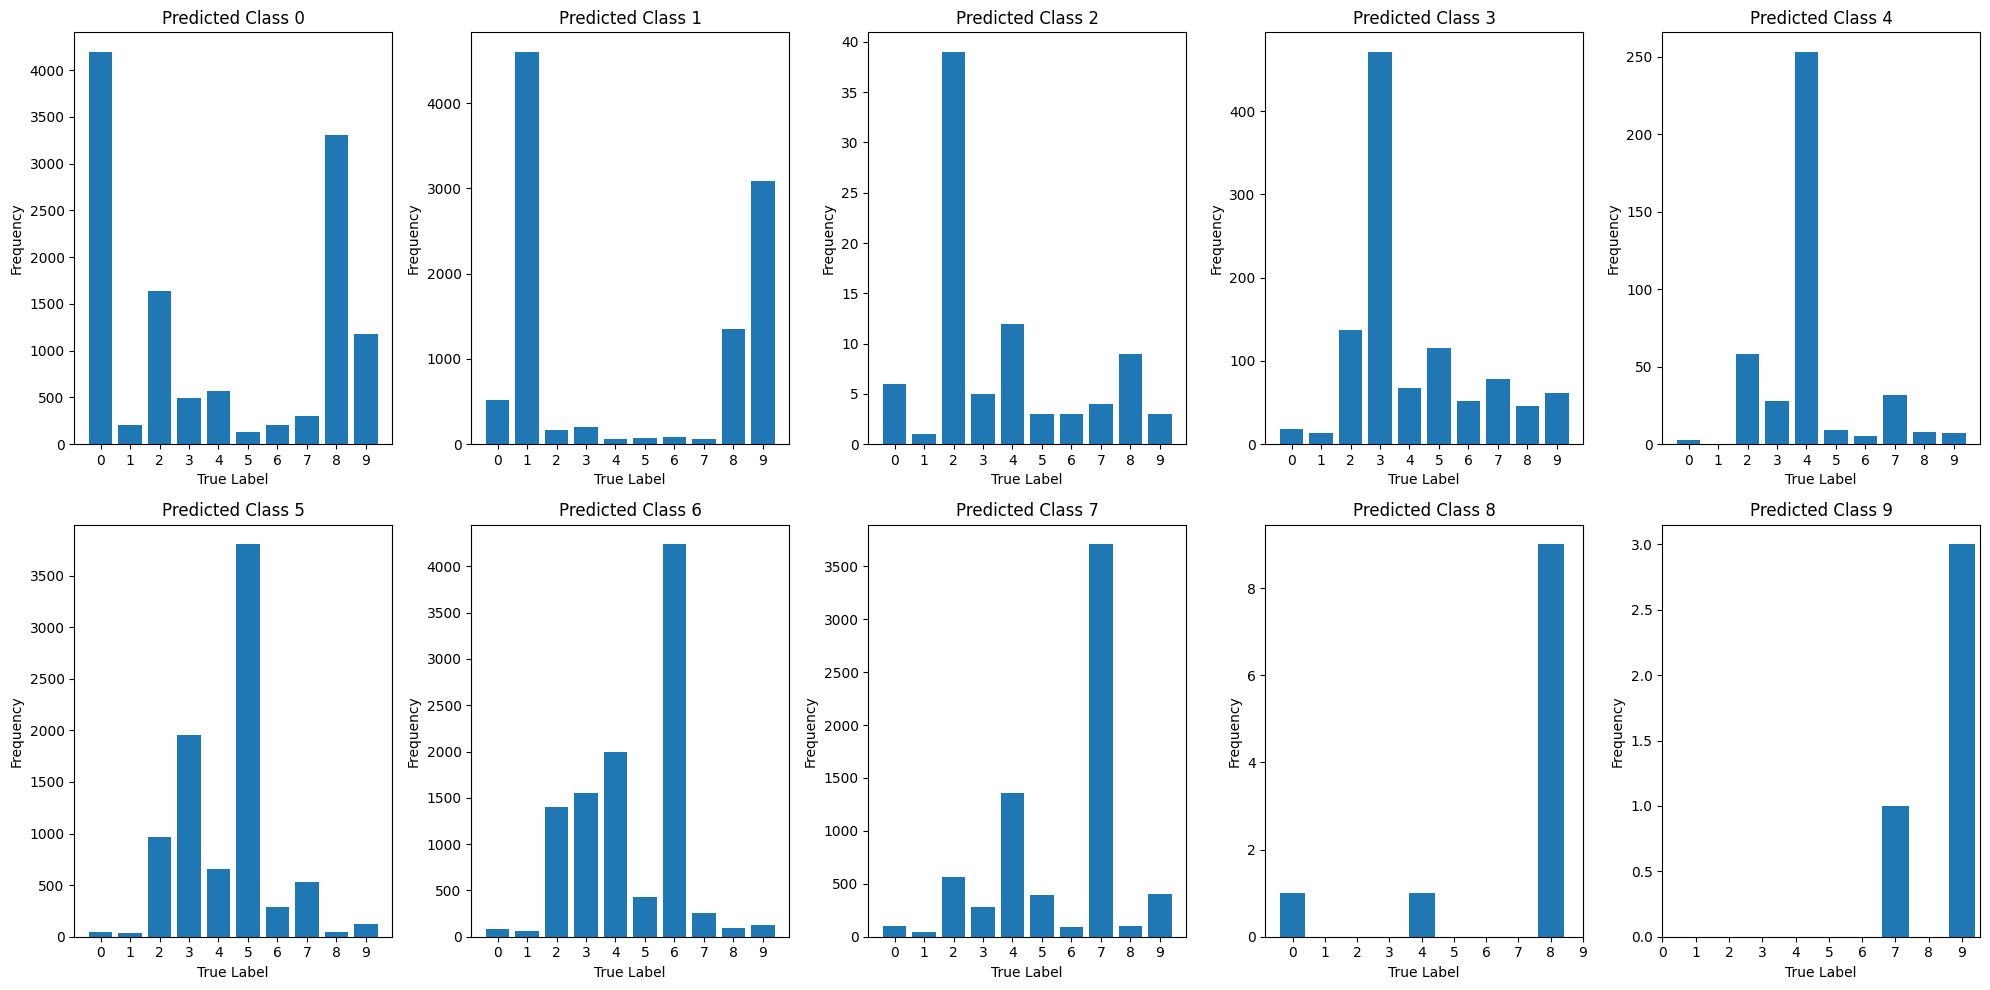

Epoch [1/3]
Processing batch 1/778
Upper: 0.949999988079071 | Lower: 0.45500001311302185
Processing batch 11/778
Upper: 0.8399999737739563 | Lower: 0.4660000205039978
Processing batch 21/778
Upper: 0.7299998998641968 | Lower: 0.47700002789497375
Processing batch 31/778
Upper: 0.619999885559082 | Lower: 0.4880000352859497
Processing batch 41/778
Upper: 0.5099997520446777 | Lower: 0.49900004267692566
Epoch [2/3]
Processing batch 1/778
Upper: 0.949999988079071 | Lower: 0.45500001311302185
Processing batch 11/778
Upper: 0.8399999737739563 | Lower: 0.4660000205039978
Processing batch 21/778
Upper: 0.7299998998641968 | Lower: 0.47700002789497375
Processing batch 31/778
Upper: 0.619999885559082 | Lower: 0.4880000352859497
Processing batch 41/778
Upper: 0.5099997520446777 | Lower: 0.49900004267692566
Epoch [3/3]
Processing batch 1/778
Upper: 0.949999988079071 | Lower: 0.45500001311302185
Processing batch 11/778
Upper: 0.8399999737739563 | Lower: 0.4660000205039978
Processing batch 21/778
Upper

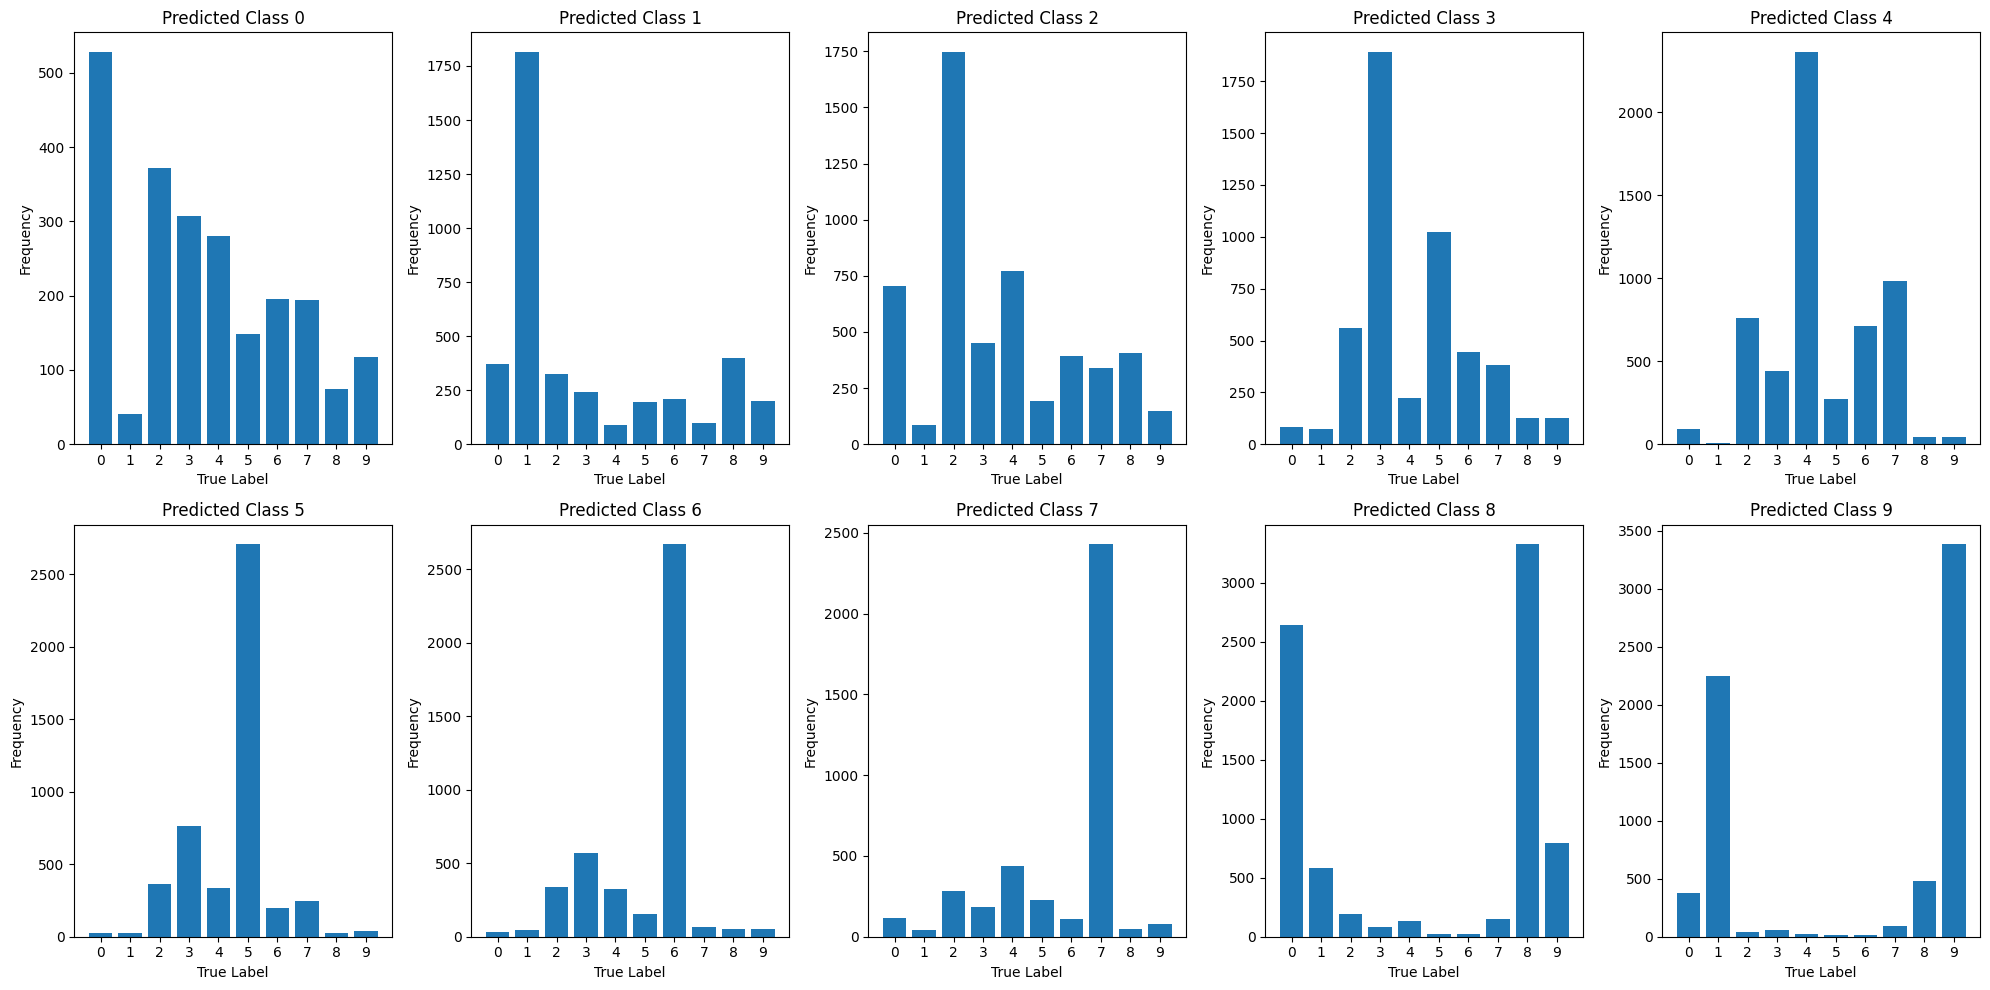

In [4]:
# Load the CIFAR-10 dataset
cifar10 = datasets.CIFAR10("./datasets", download=True)

num_images = len(cifar10)
print(num_images)
split_size = num_images // 200
remaining_size = num_images - split_size


labeled_data, dummy_unlabeled = random_split(cifar10, [split_size, remaining_size])
print(f"""Number of labeled data: {len(labeled_data)}\nNumber of unlabeled data: {len(dummy_unlabeled)}
      """)

dac = DAC()
dac.fit(labeled_data)
clusters = dac.cluster(dummy_unlabeled)



## MNIST

60000
Number of labeled data: 200
Number of unlabeled data: 59800
Epoch [1/3], Step [1/7], Loss: 2.3205
Epoch [2/3], Step [1/7], Loss: 1.9866
Epoch [3/3], Step [1/7], Loss: 1.7310
Accuracy: 0.8272
Precision: 0.8653
Recall: 0.8238
F1 Score: 0.7867
Adjusted Rand Index: 0.7215
Normalized Mutual Information: 0.7650


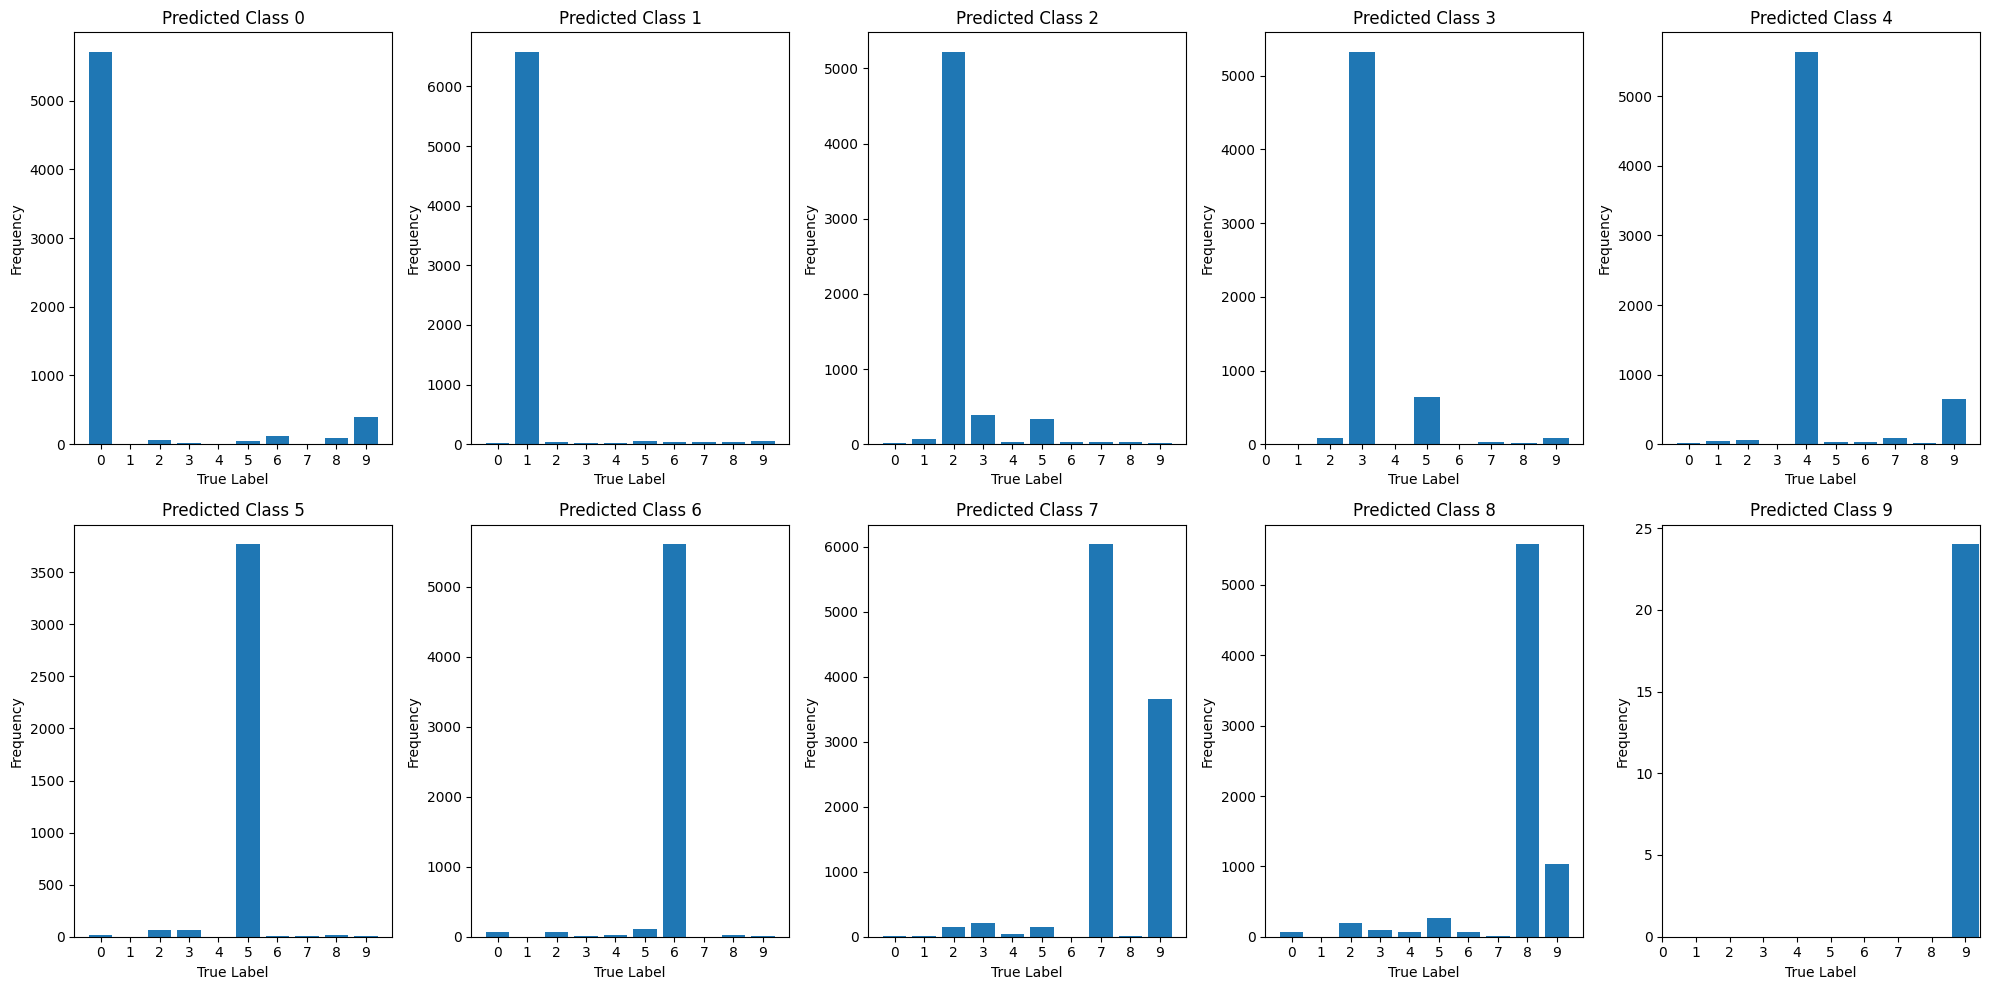

Epoch [1/3]
Processing batch 1/1869
Upper: 0.949999988079071 | Lower: 0.45500001311302185
Processing batch 11/1869
Upper: 0.8399999737739563 | Lower: 0.4660000205039978
Processing batch 21/1869
Upper: 0.7299998998641968 | Lower: 0.47700002789497375
Processing batch 31/1869
Upper: 0.619999885559082 | Lower: 0.4880000352859497
Processing batch 41/1869
Upper: 0.5099997520446777 | Lower: 0.49900004267692566
Epoch [2/3]
Processing batch 1/1869
Upper: 0.949999988079071 | Lower: 0.45500001311302185
Processing batch 11/1869
Upper: 0.8399999737739563 | Lower: 0.4660000205039978
Processing batch 21/1869
Upper: 0.7299998998641968 | Lower: 0.47700002789497375
Processing batch 31/1869
Upper: 0.619999885559082 | Lower: 0.4880000352859497
Processing batch 41/1869
Upper: 0.5099997520446777 | Lower: 0.49900004267692566
Epoch [3/3]
Processing batch 1/1869
Upper: 0.949999988079071 | Lower: 0.45500001311302185
Processing batch 11/1869
Upper: 0.8399999737739563 | Lower: 0.4660000205039978
Processing batch 

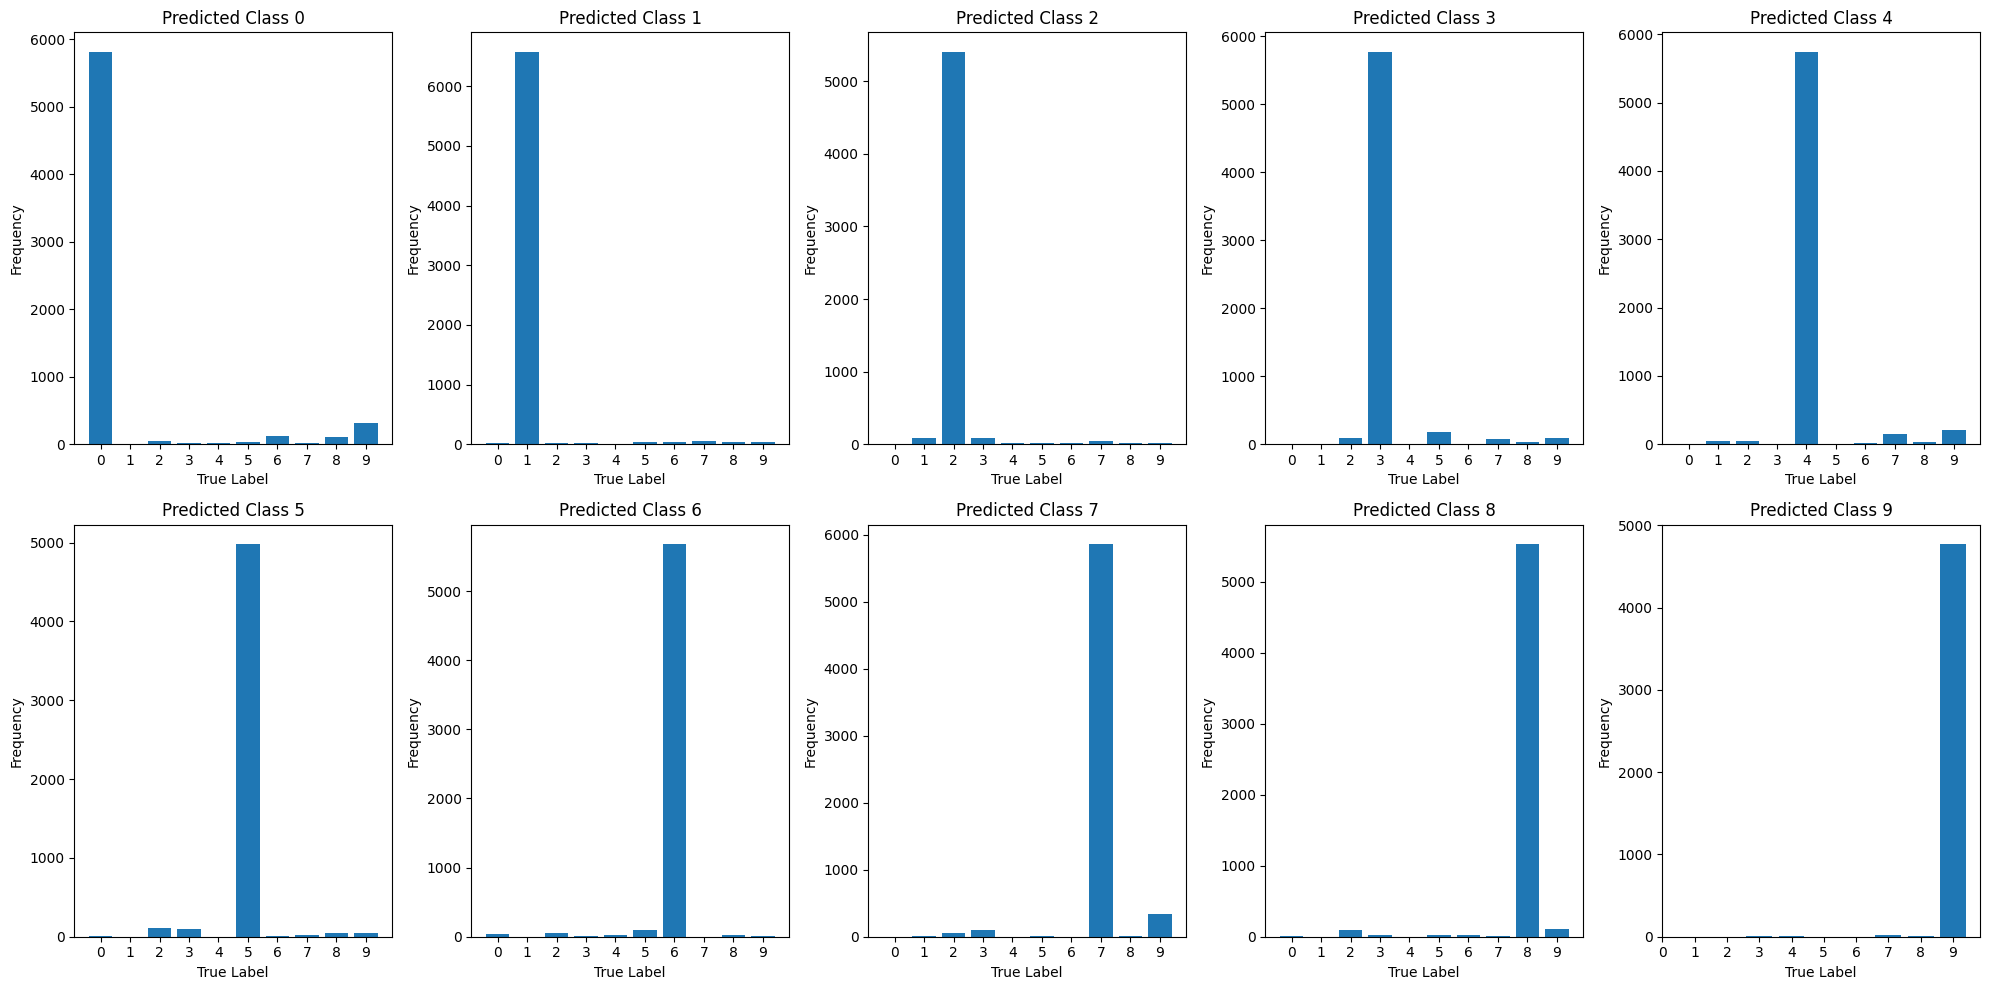

In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

mnist_dataset = MNIST(root="./datasets", download=True, transform=transforms.Grayscale(num_output_channels=3))

num_images = len(mnist_dataset)
print(num_images)
split_size = num_images // 300
remaining_size = num_images - split_size

labeled_data, dummy_unlabeled = random_split(mnist_dataset, [split_size, remaining_size // 10])
print(f"""Number of labeled data: {len(labeled_data)}\nNumber of unlabeled data: {len(dummy_unlabeled)}""")

dac = DAC()
dac.fit(labeled_data)
clusters = dac.cluster(dummy_unlabeled)

In [ ]:
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from model_name import Model
from feature_generator import FeatureGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plot_clusters(data, labels, title):
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_data = data[labels == label]
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {label}', alpha=0.5)
    plt.title(title)
    plt.legend()
    plt.show()

def evaluate_clustering(true_labels, pred_labels):
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    ari = adjusted_rand_score(true_labels, pred_labels)
    print(f'Normalized Mutual Information: {nmi:.4f}')
    print(f'Adjusted Rand Index: {ari:.4f}')
    
    
    
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

cifar10 = datasets.CIFAR10("./datasets", download=True, transform=preprocess)
num_images = len(cifar10)
split_size = num_images // 100
remaining_size = num_images - split_size

subset, _ = random_split(cifar10, [split_size, remaining_size])
print(f"Using {len(subset)} images out of {num_images} total images.")

data_loader = DataLoader(subset, batch_size=32, shuffle=False)
feature_generator = FeatureGenerator(Model.RES_NET_34, pretrained=True)
all_features = []
all_labels = []

for img_batch, label_batch in data_loader:
    features = feature_generator.generate(img_batch)
    features = features.view(features.size(0), -1) 
    all_features.append(features.cpu().numpy())
    all_labels.append(label_batch.cpu().numpy())

all_features = np.vstack(all_features)
all_labels = np.hstack(all_labels)

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)


eps_values = [5, 3, 1, 0.5, 0.3, 0.1, 0.05, 0.01, 0.001]
min_samples_values = [3, 5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        dbscan_labels = dbscan.fit_predict(all_features_scaled)
        
        unique_labels = np.unique(dbscan_labels)
        print(f"DBSCAN with eps={eps}, min_samples={min_samples}: {len(unique_labels)} clusters")
        
        plot_clusters(all_features_scaled, dbscan_labels, f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
        evaluate_clustering(all_labels, dbscan_labels)


# SEE-AI